In [5]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR

np.random.seed(1234)

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


### Load data 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv") 
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")
df_valid = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/valid.csv")

In [8]:
df_train_all = pd.concat([df_train, df_valid])

In [9]:
X_train = df_train_all.loc[:, df_train_all.columns != 'pIC50']
y_train = df_train_all['pIC50']

#X_train = df_train.loc[:, df_train.columns != 'pIC50']
#y_train = df_train['pIC50']

X_test = df_test.loc[:, df_test.columns != 'pIC50']
y_test = df_test['pIC50']

#X_valid = df_valid.loc[:, df_valid.columns != 'pIC50']
#y_valid = df_valid['pIC50']

In [10]:
X_train.shape, y_train.shape

((8505, 166), (8505,))

In [11]:
X_test.shape, y_test.shape

((2127, 166), (2127,))

## Metrics 📏

In [12]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## Random Forest Regressor


In [ ]:
# default: 'n_estimators': 100, 'max_depth': None

params = {
    'max_depth': [5, 10, 12, 13],
    'n_estimators': [500, 1000, 1500, 2000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 13, 'n_estimators': 2000} 

Test set:
Tuned model:
MAE: 0.4304155233370943
MSE: 0.3676015177144546
RMSE: 0.6063015072671802
R2 Square 0.589589664471442 

Base model:
MAE: 0.4332971338786334
MSE: 0.37361099511869844
RMSE: 0.6112372658131198
R2 Square 0.5828803569224377 

Train set:
Tuned model:
MAE: 0.30752515688361093
MSE: 0.18252801533626842
RMSE: 0.42723297547856537
R2 Square 0.7989730919550547 

Base model:
MAE: 0.3103269369509304
MSE: 0.18613164037921492
RMSE: 0.4314297629733198
R2 Square 0.7950042458642107 



In [ ]:
params = {'max_depth': 13, 'n_estimators': 2000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 0.43026173464346595
MSE: 0.36725315895173444
RMSE: 0.6060141573855634
R2 Square 0.589978591148299 

Train set:
MAE: 0.30748398322951254
MSE: 0.1824987991454442
RMSE: 0.42719878176961623
R2 Square 0.7990052691553351 



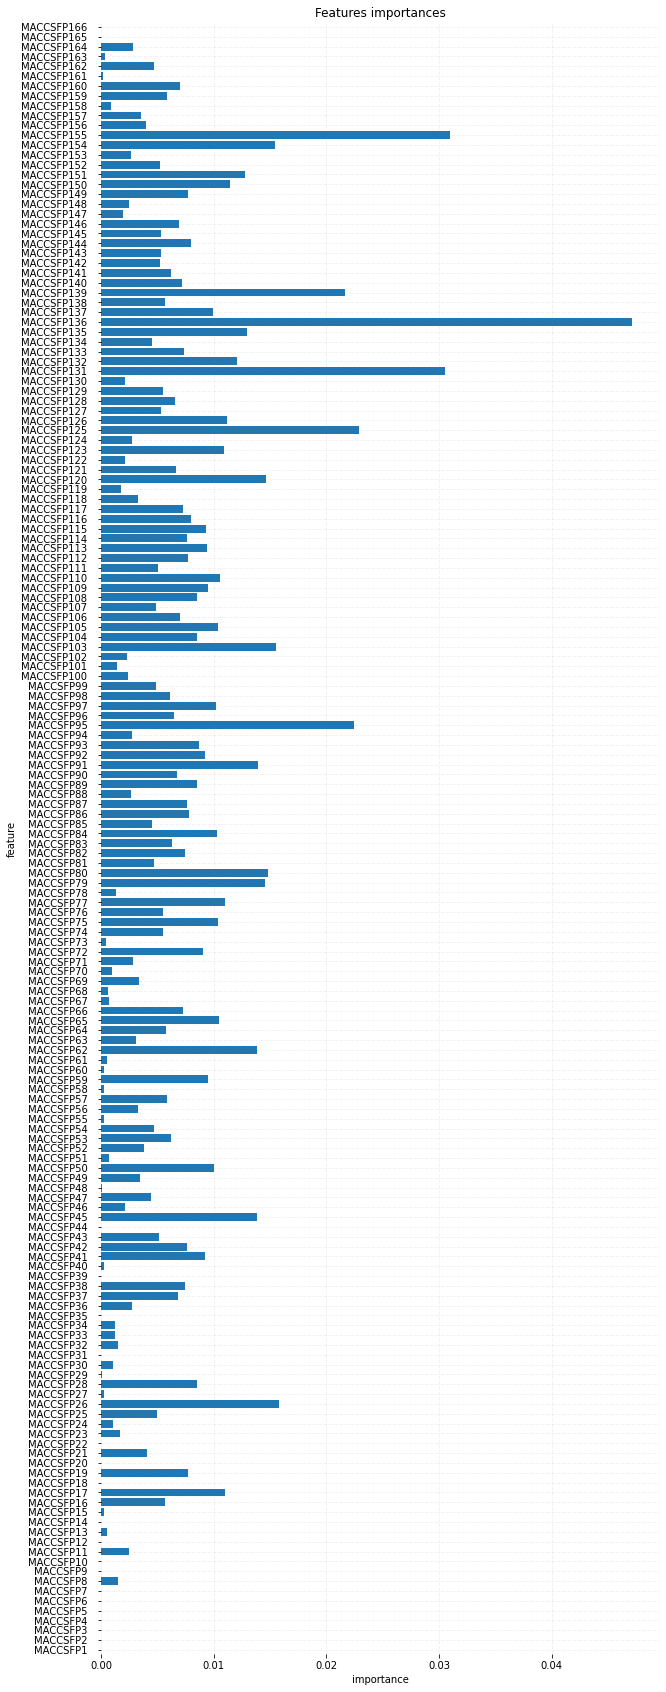

In [ ]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [ ]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.611536,0.682949,0.826408,0.237518
1,Random Forest Regressor,0.430262,0.367253,0.606014,0.589979


## XGBoost


In [ ]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [4, 8, 10, 15],
    'n_estimators': [500, 1000, 2000, 3000, 4000],
    'min_child_weight': [155, 185, 225],
    'colsample_bytree': [0.3],
    'subsample': [0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 155, 'n_estimators': 4000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.44028675789075533
MSE: 0.3822356753727693
RMSE: 0.6182521131162992
R2 Square 0.5732512946190299 

Base model:
MAE: 0.45521936619538306
MSE: 0.3932633415908227
RMSE: 0.6271071213045046
R2 Square 0.5609394080392692 

Train set:
Tuned model:
MAE: 0.3505214977733569
MSE: 0.2424777150006896
RMSE: 0.49242026258135396
R2 Square 0.7329475958712925 

Base model:
MAE: 0.3552807231479518
MSE: 0.245729066713452
RMSE: 0.4957106683474262
R2 Square 0.7293667253918807 



In [ ]:
params = {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 155, 'n_estimators': 4000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 0.44028675789075533
MSE: 0.3822356753727693
RMSE: 0.6182521131162992
R2 Square 0.5732512946190299 

Train set:
MAE: 0.3505214977733569
MSE: 0.2424777150006896
RMSE: 0.49242026258135396
R2 Square 0.7329475958712925 



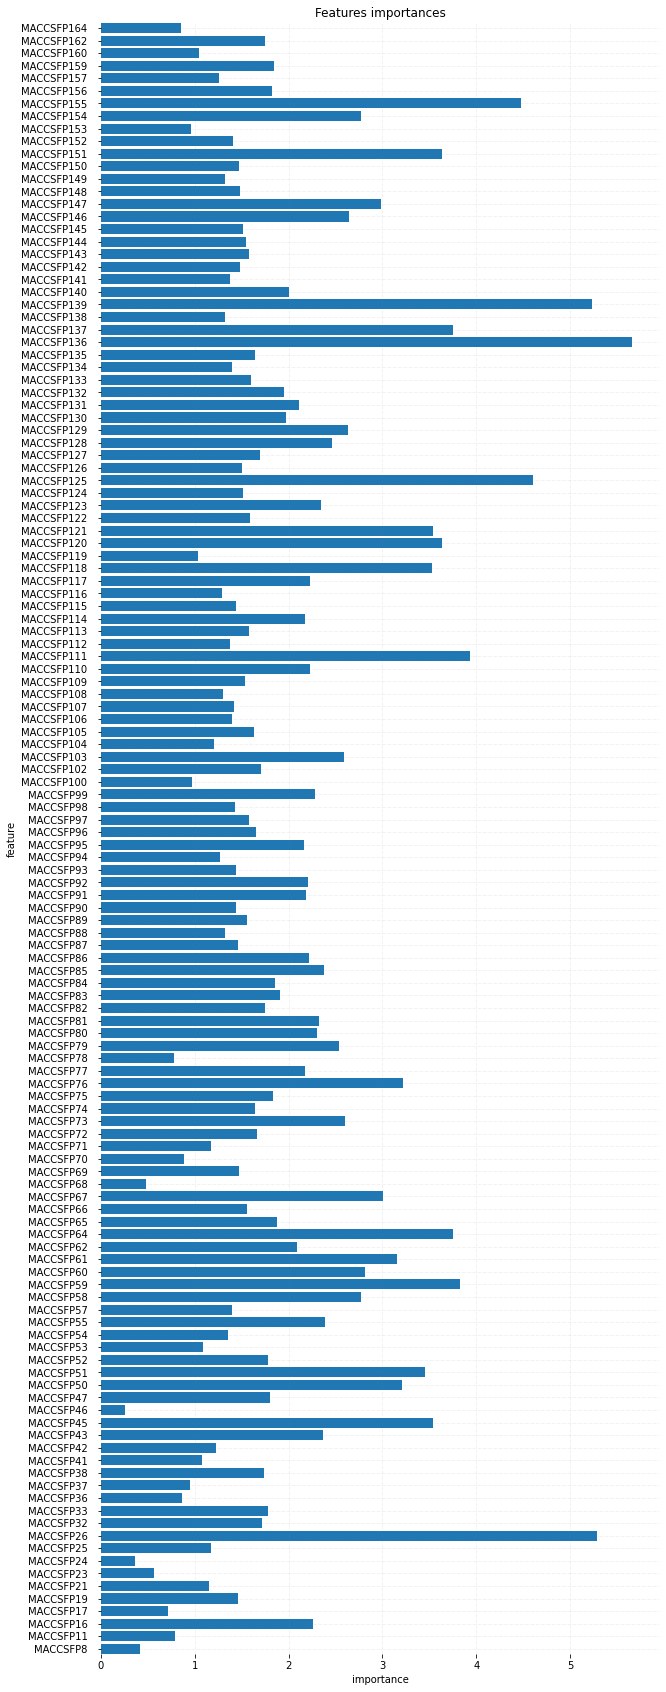

In [ ]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [ ]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.611536,0.682949,0.826408,0.237518
1,Random Forest Regressor,0.430262,0.367253,0.606014,0.589979
2,XGBoost,0.440287,0.382236,0.618252,0.573251


## Support Vector Regression

Better results - fifth model.

In [ ]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 2.0, 3.0],
    'epsilon': [0.1, 0.001, 0.0001],
}

grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 3.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 0.425477374263533
MSE: 0.3887616048374761
RMSE: 0.6235075018293493
R2 Square 0.5659653918896335 

Base model:
MAE: 0.45771425640822616
MSE: 0.4633830727671194
RMSE: 0.6807224638331831
R2 Square 0.48265392494833637 

Train set:
Tuned model:
MAE: 0.29682886498825867
MSE: 0.24335978584990098
RMSE: 0.49331509793427264
R2 Square 0.7319761286958737 

Base model:
MAE: 0.3793564384022883
MSE: 0.3645100521503306
RMSE: 0.6037466787903107
R2 Square 0.5985474963934336 



In [ ]:
params = {'C': 3.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 0.425477374263533
MSE: 0.3887616048374761
RMSE: 0.6235075018293493
R2 Square 0.5659653918896335 

Train set:
MAE: 0.29682886498825867
MSE: 0.24335978584990098
RMSE: 0.49331509793427264
R2 Square 0.7319761286958737 



In [ ]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

### Averaging base models with k-fold cross validation

In [ ]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
    
        
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 0.40951938266203575
Model1 R2: 0.53704336518686
Model2 MSE: 0.3930138955863381
Model2 R2: 0.5557026157035149
Model3 MSE: 0.41313331361289274
Model3 R2: 0.5329578606117651
Model4 MSE: 0.4240947163664964
Model4 R2: 0.5205661293617017
Model5 MSE: 0.39563254374355245
Model5 R2: 0.5527422661084773
Average MSE = 0.40707877039426305
Average R2 = 0.5398024473944638
-------------- fold 2 --------------
Model1 MSE: 0.39224774023861647
Model1 R2: 0.5937531731317698
Model2 MSE: 0.39579338533236014
Model2 R2: 0.5900809860908501
Model3 MSE: 0.42158237706020807
Model3 R2: 0.5633716007131397
Model4 MSE: 0.408693604298808
Model4 R2: 0.5767203660453739
Model5 MSE: 0.41715788919364316
Model5 R2: 0.5679539958984263
Average MSE = 0.40709499922472714
Average R2 = 0.5783760243759121
-------------- fold 3 --------------
Model1 MSE: 0.38298460480524993
Model1 R2: 0.5446091828660766
Model2 MSE: 0.39292300285708787
Model2 R2: 0.532791853519039
Model3 MSE: 0.417491

In [ ]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [ ]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [ ]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.565891,4.721757,4.682211,4.769711,4.497236
1,4.565056,4.436015,4.482491,4.536186,4.481627
2,5.015518,5.199195,5.173862,4.961750,5.057909
3,5.366305,5.419013,5.351678,5.434595,5.251501
4,4.458038,4.423059,4.557781,4.552135,4.260542
...,...,...,...,...,...
8500,4.971285,4.830356,4.845230,4.923889,4.937124
8501,4.397270,4.398889,4.466794,4.539913,4.259046
8502,5.466917,5.792490,5.951499,5.547861,5.581300
8503,4.718400,5.077339,4.989357,4.860691,4.644528


In [ ]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.523151,3.900594,3.881707,4.137091,3.960993
1,4.679182,4.708101,4.787435,4.869472,4.477848
2,4.711639,4.646130,4.612341,4.666858,4.478979
3,4.883928,4.827970,4.896827,4.851108,4.847551
4,5.420980,5.293620,5.376264,5.465123,5.304389
...,...,...,...,...,...
2122,4.850102,5.013459,4.997690,5.181720,4.919855
2123,5.662517,5.868940,5.832285,5.512957,5.895853
2124,4.993517,4.842488,4.854456,5.025973,4.750154
2125,6.001013,6.296697,6.242978,6.046583,6.193216


In [ ]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 0.4152852557717902
MSE: 0.35291682408135056
RMSE: 0.5940680298428376
R2 Square 0.6059844554357648 

Train set:
MAE: 0.42057726652551736
MSE: 0.36687191816056747
RMSE: 0.6056995279514155
R2 Square 0.595946259425072 

